# Setup

In [1]:
from ultralytics import YOLO, RTDETR
from matplotlib import pyplot as plt
import cv2
import torch
import os
import numpy as np
import random
import json
import sys
from datetime import datetime

# os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3" # replace with the GPU IDs that are available

# to help with reproducibility
seed=0
import torch.backends.cudnn as cudnn 
random.seed(seed) 
np.random.seed(seed) 
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)   
cudnn.benchmark, cudnn.deterministic = False, True
                                        
np.set_printoptions(precision=9)

sys.path.append('../') # workaround for lack of relative import in notebooks
from sam_predictor import predictor_utils, astro_sam, residualAttentionBlock
from losses import metrics_utils
from dataset import dataset_utils

In [2]:
kfold_iter=0

device_id=1
batch_size=8
lr=3e-5
wd=0.0005
wandb_track=True
torch.cuda.set_device(device_id)
datetime_now = datetime.now()

if wandb_track:
    # !pip install wandb
    # !wandb login
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime_now}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: iuliaelisa15. Use `wandb login --relogin` to force relogin


In [3]:
yolo_dataset_path = '../data/xami_dataset_YOLO/' 

In [4]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print(classes)

coco_data_path = f'../data/xami_dataset/'
annotations_file = '_annotations.coco.json'

with open(coco_data_path+'train/'+annotations_file, 'r') as f1, open(coco_data_path+'valid/'+annotations_file, 'r') as f2:
    train_coco_data = json.load(f1)
    valid_coco_data = json.load(f2)

{0: 'central-ring', 1: 'other', 2: 'read-out-streak', 3: 'smoke-ring', 4: 'star-loop'}


In [5]:
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'

train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

# Model setup

In [6]:
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'mobile_sam'))
from mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
# mobile_sam_checkpoint = './weights/sam_weights/sam_0_best.pth'
# mobile_sam_checkpoint = './output_sam_test/sam_0_2024-05-30 05:48:56.559611_best.pth'
mobile_sam_checkpoint = './output_sam_test/sam_0_2024-05-30 05:33:37.638572_best.pth'

# detector_pretrained_model = YOLO(f'./weights/yolo_weights/last.pt');
detector_pretrained_model = RTDETR(f'./rt-detr-iter0/rtdetr-l2/weights/last.pt');

detector_pretrained_model.to(device);
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

/workspace/raid/OM_DeepLearning/XAMI-model/train/../mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/XAMI-model/train/../mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/XAMI-model/train/../mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an ex

In [7]:
# astrosam_model = astro_sam.AstroSAM(mobile_sam_model, device, predictor)
astrosam_model = astro_sam.AstroSAM(
    mobile_sam_model, 
    device, 
    predictor, 
    use_yolo_masks=False, 
    wt_threshold=0.6, 
    wt_classes_ids = [1.0, 4.0],
    apply_segm_CR=True)

In [8]:
for name, param in mobile_sam_model.named_parameters():
    if 'mask_decoder' in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False
        
print(f"🚀 The model has {sum(p.numel() for p in astrosam_model.model.parameters() if p.requires_grad)} trainable parameters.")

🚀 The model has 4058340 trainable parameters.


In [9]:
import tqdm
from tqdm import tqdm

train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd) if len(parameters_to_optimize) > 0 else None

## Define metrics

In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric_thresholds = [[0.5], [0.75], [0.5, 0.9]]

# Train

In [11]:
from collections import defaultdict

best_valid_loss = float('inf')
num_epochs = 1
n_epochs_stop = num_epochs // 10 + 5
all_metrics = defaultdict(dict)
compute_metrics = True

In [12]:
# Intro
predictor_utils.print_training_intro(
    train_image_files, valid_image_files, device, metric_thresholds, num_epochs, 
    batch_size, lr, wd, wandb_track, mobile_sam_model, 'AdamW')

# Training loop
for epoch in range(num_epochs):

    # Train
    astrosam_model.model.train()
    train_results = astrosam_model.run_yolo_sam_epoch(
        detector_pretrained_model,
        phase='train',
        batch_size=batch_size, 
        image_files=train_image_files, 
        images_dir=train_dir, 
        num_batches=train_num_batches,
        optimizer=optimizer) 
    
    epoch_sam_loss_train, train_preds, train_gts = train_results[:3]
    train_gt_classes, train_pred_classes, train_all_iou_scores, train_mask_areas, _ = train_results[3:]

    # Validate
    astrosam_model.model.eval()
    with torch.no_grad():
        valid_results = astrosam_model.run_yolo_sam_epoch(
            detector_pretrained_model,
            phase='val',
            batch_size=batch_size, 
            image_files=valid_image_files, 
            images_dir=valid_dir, 
            num_batches=valid_num_batches,
            optimizer=None) 

    epoch_sam_loss_val, valid_preds, valid_gts = valid_results[:3]
    valid_gt_classes, valid_pred_classes, valid_all_iou_scores, valid_mask_areas, pred_images = valid_results[3:]

    # Early stopping                                                                                
    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = astrosam_model.model
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break
        
    # Metrics
    if compute_metrics:
        for threshold in tqdm(metric_thresholds, desc="(Metrics) Processing thresholds", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            metric = MeanAveragePrecision(
            iou_type = "segm", 
            iou_thresholds = threshold, 
            max_detection_thresholds=[1, 10, 100],
            class_metrics=True,
            extended_summary=False)
            
            train_metrics = metrics_utils.mAP_metrics(metric,
            train_preds,
            train_gts, 
            train_gt_classes, 
            train_pred_classes, 
            train_all_iou_scores,
            train_mask_areas,
            show_metrics=False) 
                
            valid_metrics = metrics_utils.mAP_metrics(metric,
                    valid_preds,
                    valid_gts, 
                    valid_gt_classes, 
                    valid_pred_classes, 
                    valid_all_iou_scores,
                    valid_mask_areas,
                    show_metrics=False)
        
            all_metrics[tuple(threshold)] = {'train': train_metrics, 'valid': valid_metrics}

        # Prints
        if not wandb_track:
            wandb = None
        predictor_utils.prints_and_wandb(
            epoch, 
            epoch_sam_loss_train, 
            epoch_sam_loss_val, 
            all_metrics, 
            metric_thresholds,
            wandb)

    # Checkpoint save
    # torch.save(best_model.state_dict(), f'./output_sam/yolo_sam_{epoch}.pth')

# torch.save(astrosam_model.model.state_dict(), f'./output_sam_test/yolo_sam_final.pth')

# Finish wandb run
if wandb_track:
    run.finish()
        
if compute_metrics:   
    metrics_dict = defaultdict(dict)
    metrics_dict[f'{metric_thresholds[0][0]}'] = predictor_utils.convert_tensors(all_metrics[tuple(metric_thresholds[0])])
    metrics_dict[f'{metric_thresholds[1][0]}'] = predictor_utils.convert_tensors(all_metrics[tuple(metric_thresholds[1])])
    metrics_dict[f'{metric_thresholds[2][0]}-{metric_thresholds[2][1]}'] = predictor_utils.convert_tensors(all_metrics[tuple(metric_thresholds[2])])
    metrics_dict['best_epoch'] = best_epoch
    
    with open(f'metrics_{datetime_now}.json', 'w') as json_file:
        json.dump(metrics_dict, json_file, indent=4)

Model Training Configuration:
 - Training images: 791
 - Validation images: 264
 - Number of Epochs: 1
 - Batch Size: 8
 - Learning Rate: 3e-05
 - Weight Decay: 0.0005
 - Device: cuda:1
 - mAP thresholds: [[0.5], [0.75], [0.5, 0.9]]
 - Early Stopping: Stop if no improvement after 5 epochs.
 - Weights & Biases Tracking: Enabled.
 - Optimizer: AdamW.
 - Total Trainable Parameters: 4,058,340


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:36<00:00, 12.07s/it]                                                                                                   


Train mAP[0.5]: 96.0. Valid mAP[0.5]: 91.5
Train mAP[0.75]: 84.80000305175781. Valid mAP[0.75]: 77.80000305175781
Train mAP[0.5, 0.9]: 60.599998474121094. Valid mAP[0.5, 0.9]: 56.5
Epoch 0. Train loss: 1.1074454
Epoch 0. Validation loss: 1.1871481


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
# torch.save(astrosam_model.model.state_dict(), f'./output_sam_test/yolo_sam_final.pth')

In [13]:
best_epoch

6

In [14]:
all_metrics 

defaultdict(dict,
            {(0.5,): {'train': {'map': tensor(0.9782),
               'map_50': tensor(0.9782),
               'map_75': tensor(-1.),
               'map_small': tensor(0.9587),
               'map_medium': tensor(0.9785),
               'map_large': tensor(1.),
               'mar_1': tensor(0.4835),
               'mar_10': tensor(0.9581),
               'mar_100': tensor(0.9853),
               'mar_small': tensor(0.9638),
               'mar_medium': tensor(0.9855),
               'mar_large': tensor(1.),
               'map_per_class': tensor([1.0000, 0.9239, 0.9890, 0.9898, 0.9881]),
               'mar_100_per_class': tensor([1.0000, 0.9375, 0.9957, 0.9984, 0.9949]),
               'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)},
              'valid': {'map': tensor(0.9384),
               'map_50': tensor(0.9384),
               'map_75': tensor(-1.),
               'map_small': tensor(0.9114),
               'map_medium': tensor(0.9443),
             

In [15]:
import json

with open('metrics_2024-05-24 00:21:06.509816.json', 'r') as f1, open('metrics_2024-05-24 00:21:55.766245.json') as f2, open('metrics_2024-05-24 00:22:04.099963.json') as f3:
    data1 = json.load(f1)
    data2 = json.load(f2)
    data3 = json.load(f3)

In [16]:
for th in ['0.5', '0.75', '0.5-0.9']:
    print(th, (data1[th]['valid']['map']+ data2[th]['valid']['map']+ data3[th]['valid']['map'])/3*100 )
    print(th, 'small', (data1[th]['valid']['map_small']+ data2[th]['valid']['map_small']+ data3[th]['valid']['map_small'])/3*100 )
    print(th, 'medium', (data1[th]['valid']['map_medium']+ data2[th]['valid']['map_medium']+ data3[th]['valid']['map_medium'])/3*100 )
    print(th, 'large', (data1[th]['valid']['map_large']+ data2[th]['valid']['map_large']+ data3[th]['valid']['map_large'])/3*100 )
    map_per_class1 = data1[th]['valid']['map_per_class']
    map_per_class2 = data2[th]['valid']['map_per_class']
    map_per_class3 = data3[th]['valid']['map_per_class']
    print(th, 'map_per_class', [(map_per_class1[i]+map_per_class2[i]+map_per_class3[i])/3*100 for i in range(len(map_per_class1))])

0.5 90.1309629281362
0.5 small 82.68263936042786
0.5 medium 91.2610967954
0.5 large 84.63513056437174
0.5 map_per_class [97.60953783988953, 83.96248817443848, 82.3698083559672, 94.87569133440653, 91.83729688326517]
0.75 73.55742057164511
0.75 small 59.699430068333946
0.75 medium 75.3309448560079
0.75 large 63.490780194600426
0.75 map_per_class [94.99165415763855, 64.18589353561401, 55.28493126233419, 77.78834700584412, 75.53626894950867]
0.5-0.9 55.41555682818095
0.5-0.9 small 48.394475380579635
0.5-0.9 medium 57.184346516927086
0.5-0.9 large 58.03630352020264
0.5-0.9 map_per_class [70.24728655815125, 50.60025453567505, 48.234301805496216, 50.65420071283976, 57.34173655509949]


In [17]:
data1['0.5-0.9']['valid']['map_small'], data2['0.5-0.9']['valid']['map_small'], data3['0.5-0.9']['valid']['map_small']

(0.4822319447994232, 0.4865873456001282, 0.4830149710178375)

# Metrics visualisation

In [18]:
def ious_pred_vs_gt(gts, preds):
    all_ious_pred_vs_gt_flatten = []
    all_ious_pred_vs_gt = []
    
    for i in range(len(gts)):
        iou_image_scores = []
        for gt_mask, pred_mask in zip(gts[i], preds[i]):
            intersection = np.logical_and(gt_mask, pred_mask)
            union = np.logical_or(gt_mask, pred_mask)
            iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
            iou_image_scores.append(iou_score)
            all_ious_pred_vs_gt_flatten.append(iou_score)
        all_ious_pred_vs_gt.append(iou_image_scores)
        
    return all_ious_pred_vs_gt_flatten, all_ious_pred_vs_gt

train_all_ious_pred_vs_gt, train_ious_pred_vs_gt = ious_pred_vs_gt(train_gts, train_preds)
valid_all_ious_pred_vs_gt, valid_ious_pred_vs_gt = ious_pred_vs_gt(valid_gts, valid_preds)

In [19]:
# IoUs frequency

train_all_ious_flatten, train_mask_areas_flatten = metrics_utils.flatten_ious_areas(train_pred_classes, train_all_iou_scores, train_mask_areas)
valid_all_ious_flatten, valid_mask_areas_flatten = metrics_utils.flatten_ious_areas(valid_pred_classes, valid_all_iou_scores, valid_mask_areas)

In [20]:
np.mean(valid_all_ious_pred_vs_gt), np.std(valid_all_ious_pred_vs_gt)

(0.7445431868017482, 0.23686313418873564)

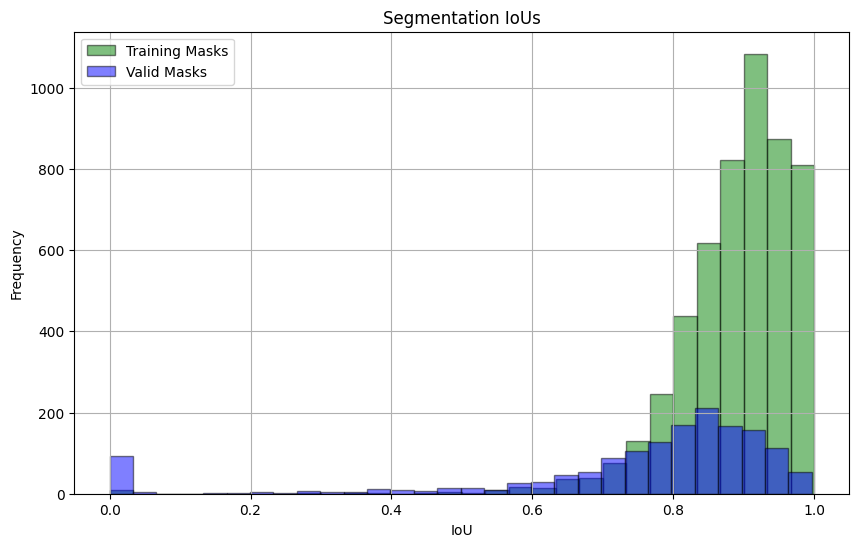

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(train_all_ious_pred_vs_gt, bins=30, alpha=0.5, color='green', edgecolor='black', label='Training Masks')
plt.hist(valid_all_ious_pred_vs_gt, bins=30, alpha=0.5, color='blue', edgecolor='black', label='Valid Masks')

plt.title('Segmentation IoUs')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
import numpy as np
from matplotlib import rcParams

rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14, 'font.family':'sans-serif'})

ious_train = train_all_ious_pred_vs_gt
ious_valid = valid_all_ious_pred_vs_gt
areas_train = train_mask_areas_flatten
areas_valid = valid_mask_areas_flatten

vals_train, base_train = np.histogram(ious_train, bins=1000, range=(0, 1), density=True)
cumulative_train = np.cumsum(vals_train * np.diff(base_train))
vals_valid, base_valid = np.histogram(ious_valid, bins=1000, range=(0, 1), density=True)
cumulative_valid = np.cumsum(vals_valid * np.diff(base_valid))

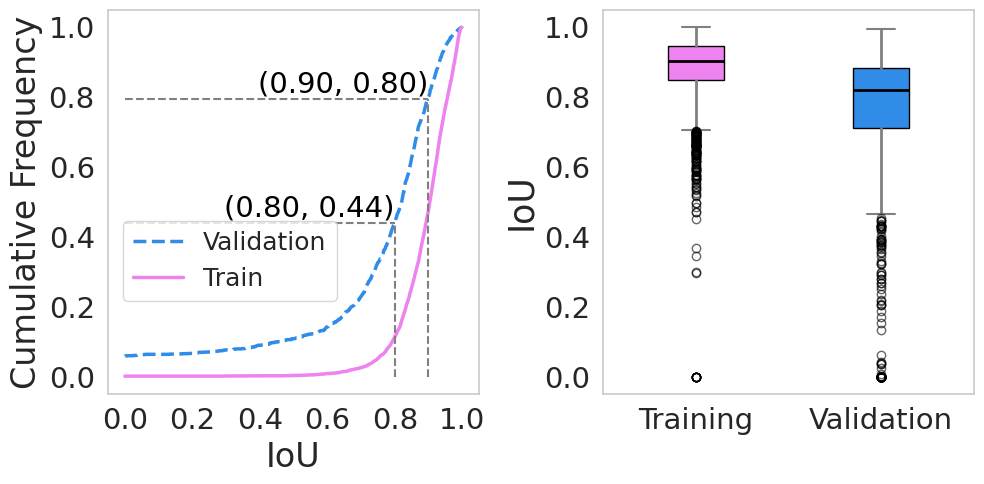

In [23]:
# plt.figure(figsize=(5, 5))
# plt.boxplot([train_all_ious_pred_vs_gt, valid_all_ious_pred_vs_gt], labels=['Training', 'Validation'], patch_artist=True)
# plt.ylabel('IoU')
# plt.grid(True)
# plt.show()
import seaborn as sns

sns.set(style="whitegrid")

# Define custom colors
colors = ['#EE82EE', '#318CE7']  # Magenta and Azure Blue

# Create a new figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Cumulative Distribution Function (CDF)
axes[0].plot(base_valid[:-1], cumulative_valid, label='Validation', color='#318CE7', linewidth=2.5, linestyle='--')
axes[0].plot(base_train[:-1], cumulative_train, label='Train', color='#EE82EE', linewidth=2.5)

quartiles_y = np.quantile(cumulative_valid, [0.8, 0.9])
quartiles_x = np.interp(quartiles_y, cumulative_valid, base_valid[:-1])

for qx, qy in zip(quartiles_x, quartiles_y):
    axes[0].hlines(qy, xmin=0, xmax=qx, colors='grey', linestyles='dashed')
    axes[0].vlines(qx, ymin=0, ymax=qy, colors='grey', linestyles='dashed')
    axes[0].text(qx, qy, f'({qx:.2f}, {qy:.2f})', fontsize=21, verticalalignment='bottom', horizontalalignment='right', color='black')

axes[0].set_xticks(np.arange(0, 1.1, 0.2))
axes[0].set_yticks(np.arange(0, 1.1, 0.2))
axes[0].set_xlabel('IoU', fontsize=24)
axes[0].set_ylabel('Cumulative Frequency', fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=21)
axes[0].legend(fontsize=18, bbox_to_anchor=(0.65, 0.21))
axes[0].grid(False)

# Plot 2: Box Plot
box = axes[1].boxplot(
    [train_all_ious_pred_vs_gt, valid_all_ious_pred_vs_gt],
    labels=['Training', 'Validation'],
    patch_artist=True,
    medianprops=dict(color='black'),
    widths=0.3
)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for whisker in box['whiskers']:
    whisker.set(color='gray', linewidth=2)
for cap in box['caps']:
    cap.set(color='gray', linewidth=1.5)
for median in box['medians']:
    median.set(color='black', linewidth=2)
for flier in box['fliers']:
    flier.set(marker='o', color='gray', alpha=0.6)  # Set outliers to gray

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Training', 'Validation'], fontsize=21)
axes[1].set_yticks(np.arange(0, 1.1, 0.2))
axes[1].set_ylabel('IoU', fontsize=25)
axes[1].tick_params(axis='both', which='major', labelsize=21)
axes[1].grid(False)

# Adjust layout for both plots to ensure consistent padding
plt.tight_layout()
# plt.savefig('../plots/combined_ious_plot.pdf', dpi=700)
plt.show()
# Set the Seaborn style for modern aesthetics
# sns.set(style="whitegrid")
# plt.figure(figsize=(5, 5))
# plt.plot(base_valid[:-1], cumulative_valid, color='#318CE7', linewidth=2.5, label=None)
# quartiles_y = np.quantile(cumulative_valid, [0.8, 0.9])
# quartiles_x = np.interp(quartiles_y, cumulative_valid, base_valid[:-1])

# for qx, qy in zip(quartiles_x, quartiles_y):
#     plt.hlines(qy, xmin=0, xmax=qx, colors='grey', linestyles='dashed')
#     plt.vlines(qx, ymin=0, ymax=qy, colors='grey', linestyles='dashed')
#     plt.text(qx, qy, f'({qx:.2f}, {qy:.2f})', fontsize=21, verticalalignment='bottom', horizontalalignment='right', color='black')

# plt.xticks(fontsize=21)
# plt.yticks(fontsize=21)
# plt.xlabel('IoU', fontsize=24)
# plt.ylabel('Cumulative Frequency', fontsize=24)
# plt.grid(False)
# plt.tight_layout()
# plt.savefig('../plots/cdf_ious.png', dpi=500)
# plt.show()

# sns.set(style="whitegrid")
# colors = ['#EE82EE', '#318CE7'] 
# plt.figure(figsize=(5, 5))
# box = plt.boxplot(
#     [train_all_ious_pred_vs_gt, valid_all_ious_pred_vs_gt],
#     labels=['Training', 'Validation'],
#     patch_artist=True,
#     medianprops=dict(color='black')
# )
# for patch, color in zip(box['boxes'], colors):
#     patch.set_facecolor(color)
# for whisker in box['whiskers']:
#     whisker.set(color='gray', linewidth=2)
# for cap in box['caps']:
#     cap.set(color='gray', linewidth=1.5)
# for median in box['medians']:
#     median.set(color='black', linewidth=2)
    
# plt.xticks(fontsize=21)
# plt.yticks(fontsize=21)
# plt.ylabel('IoU', fontsize=25)
# plt.grid(False) #, linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.savefig('../plots/ious_box_plot.png', dpi=500)
# plt.show()

In [25]:
np.max(areas_train), np.max(areas_valid)

(74093, 26290)

In [27]:
np.min(ious_train), np.max(ious_train), np.min(ious_valid), np.max(ious_valid)

(0.0, 1.0, 0.0, 0.996537795729948)

In [29]:
np.mean(valid_all_ious_pred_vs_gt), np.std(valid_all_ious_pred_vs_gt)

(0.7445431868017482, 0.23686313418873564)

### IoU TP FP FN plot (~29s)

In [30]:
def compute_metrics_with_range(gt_masks, pred_masks, image=None):
    """Compute the True Positive, False Positive, and False Negative BINARY masks for multiple segmentations."""
    
    combined_gt_mask = np.zeros_like(gt_masks[0][0], dtype=bool)
    combined_pred_mask = np.zeros_like(pred_masks[0], dtype=bool)
    filtered_pred_masks = np.zeros_like(pred_masks, dtype=bool)
      
    for gt_mask in gt_masks:
        combined_gt_mask = np.logical_or(combined_gt_mask, gt_mask)

    for pred_mask in pred_masks:
        combined_pred_mask = np.logical_or(combined_pred_mask, pred_mask.astype(bool))

    intersection = np.sum(np.logical_and(combined_gt_mask, combined_pred_mask))
    union = np.sum(np.logical_or(combined_gt_mask, combined_pred_mask))

    iou = intersection/union
    
    true_positive_mask = np.logical_and(combined_gt_mask, combined_pred_mask)
    false_negative_mask = np.logical_and(combined_gt_mask, np.logical_not(combined_pred_mask))
    false_positive_mask = np.logical_and(combined_pred_mask, np.logical_not(combined_gt_mask))

    return true_positive_mask, false_positive_mask, false_negative_mask, iou

Indices: [217, 92, 3, 46, 109, 158, 64, 79] Images: ['S0742980101_L_png.rf.f9faa8380eec120414b58c916099729a.jpg', 'S0164570601_M_png.rf.4f67a69493e16d0cab2e62f56e730d5b.jpg', 'S0511001101_L_png.rf.a280de071ca2519116b24f245362daed.jpg', 'S0306090401_M_png.rf.4fa9c975aa72e3ee7ddbb32a864e64e4.jpg', 'S0741032601_B_png.rf.94bee44d7d67b89a7dfa5ed25eec7fa2.jpg', 'S0153450101_B_png.rf.159e7cf836b56010094724496fdae87f.jpg', 'S0747440139_L_png.rf.f92c971b4c799f5fd1cafdd79de96ec8.jpg', 'S0074140101_B_png.rf.f159bc63fb07c8b1e5b1f3fbe10815db.jpg']

Plotting...


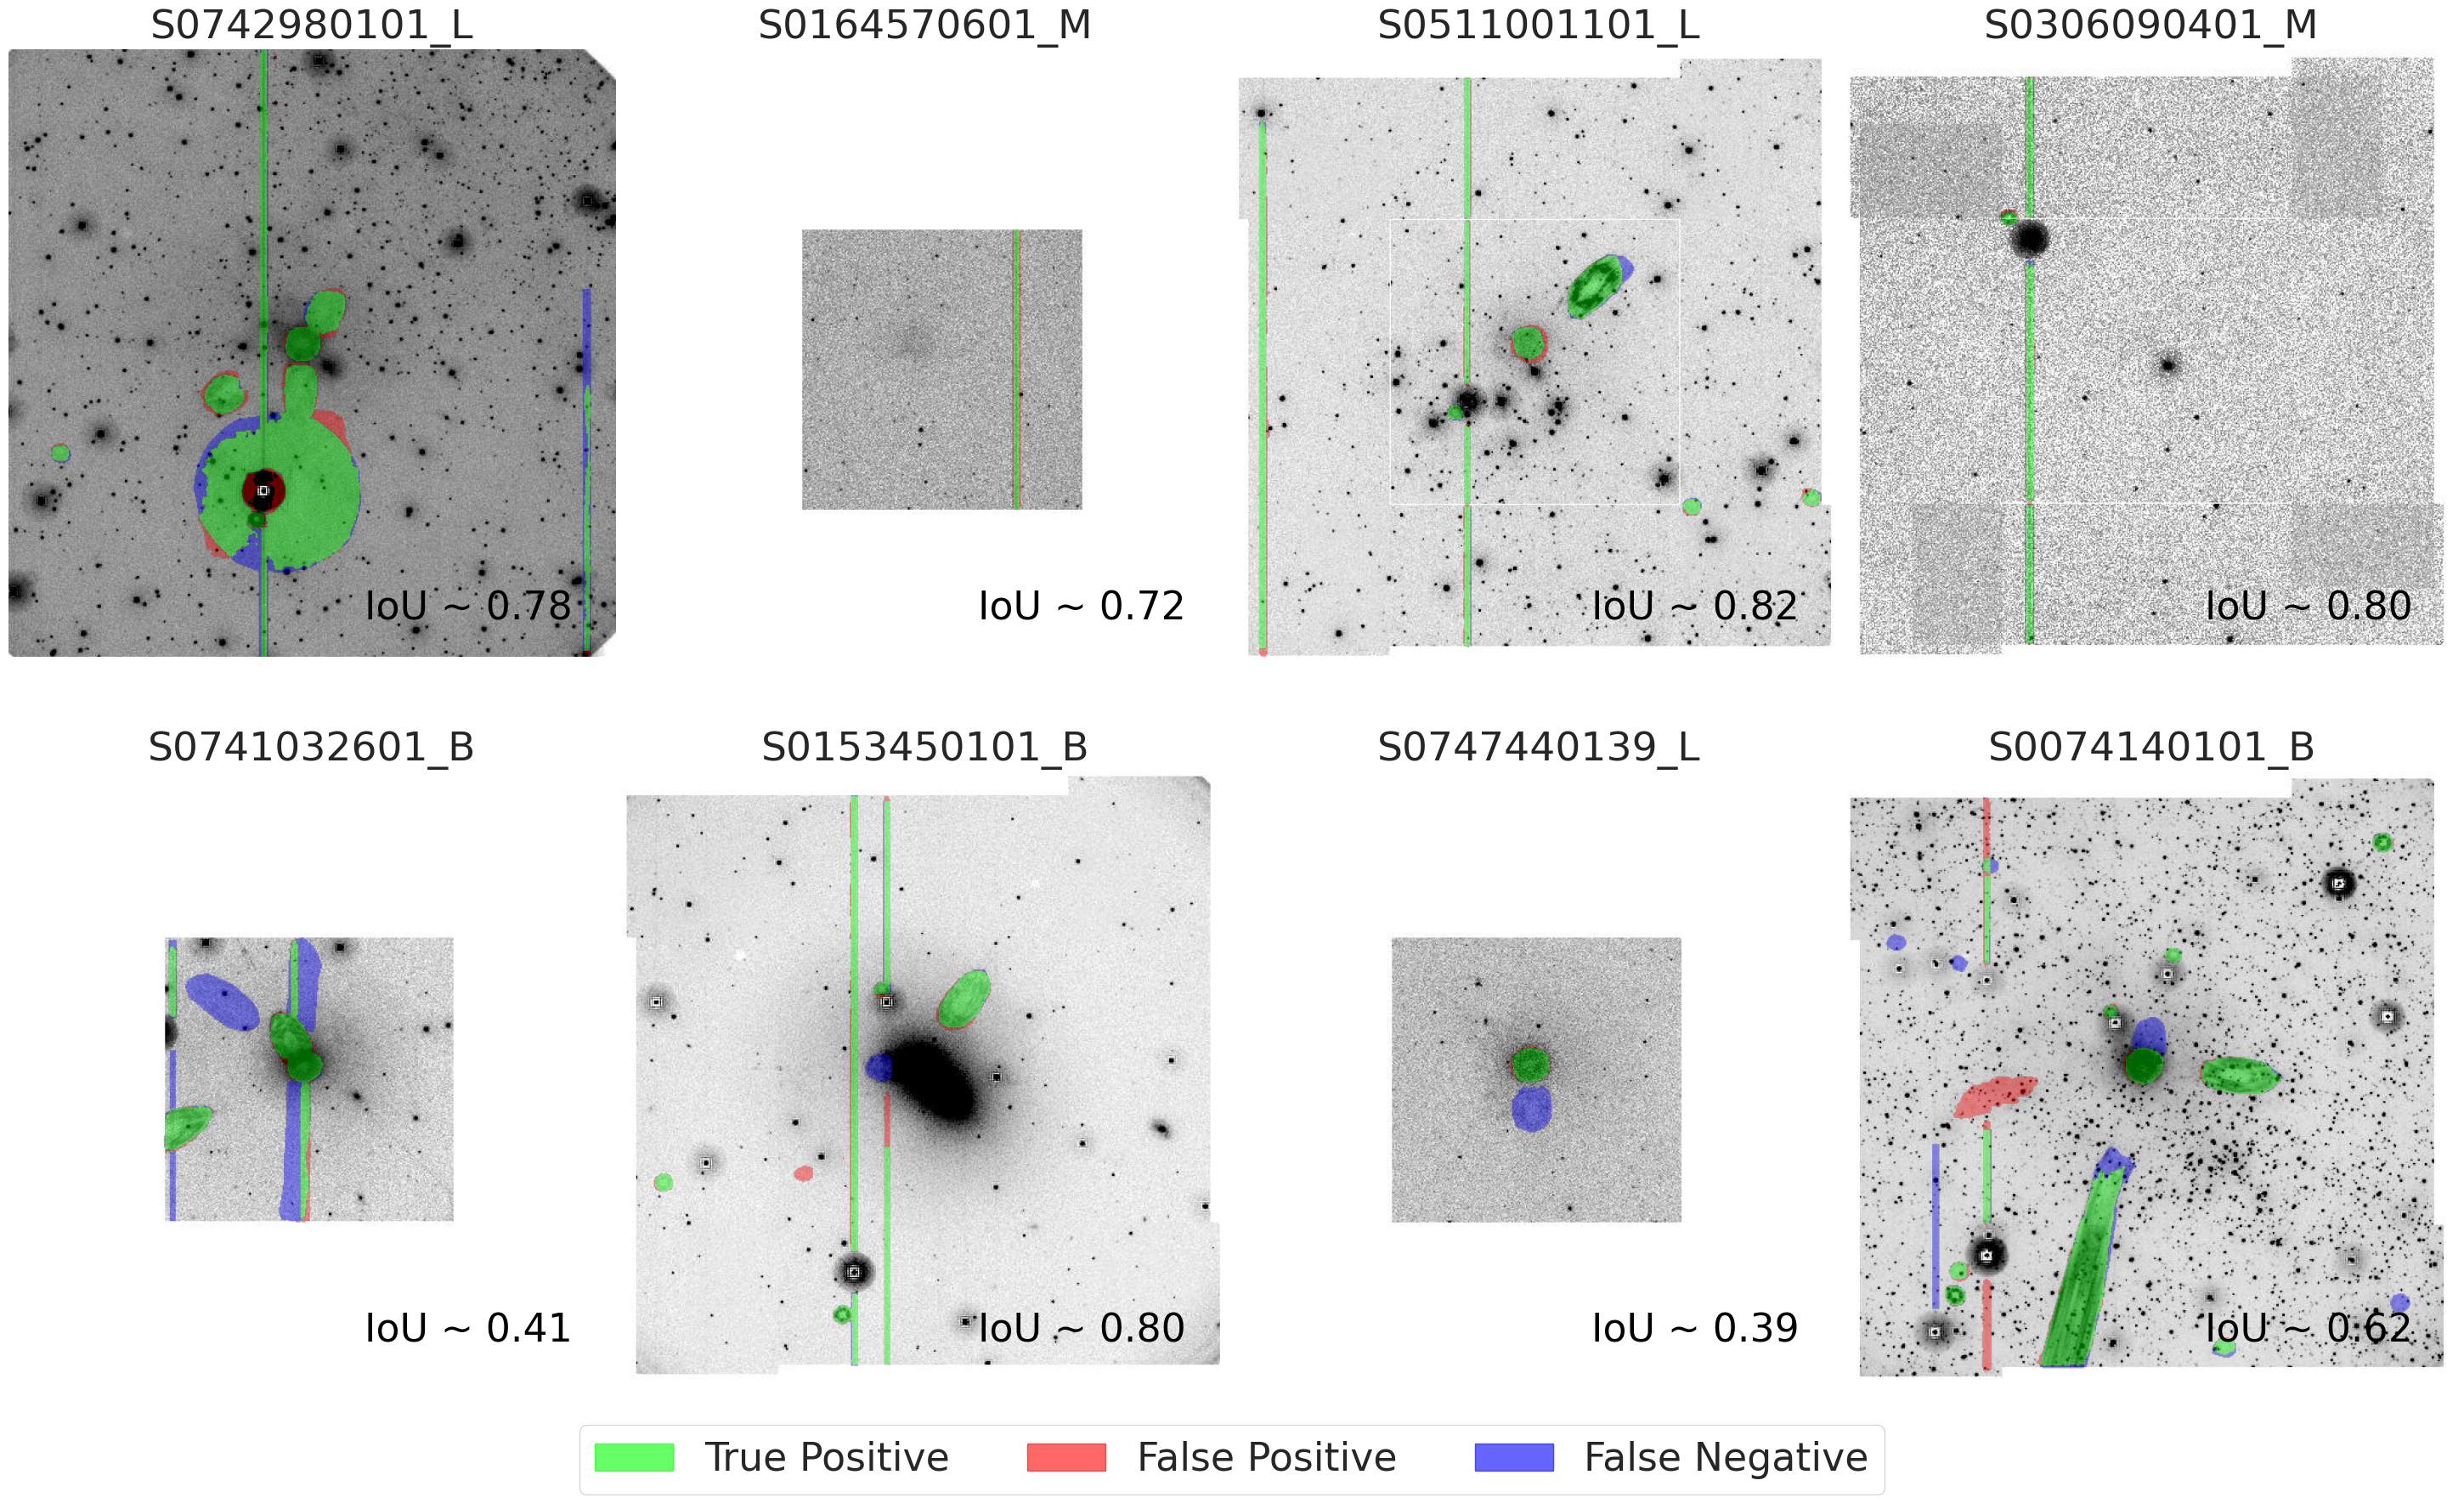

In [34]:
import random
import matplotlib.patches as mpatches
from matplotlib import style
from matplotlib.colors import LinearSegmentedColormap

# 64: 0.83
# 204: 0.8
# 158: 0.77
# 72: 0.88
# 136: 0.96
# 18: 0.92
# 79: 0.91
# 217: 0.23
# 163: 0.7
# 141: 0.56
# 92: 0.36
# 46; 0.5
# 109: 0.63

# random_indices = random.sample(range(len(pred_images)), 8)
random_indices = [217,92,3,46,109,158,64,79 ]
images = [pred_images[i] for i in random_indices]
selected_gts = [valid_gts[i] for i in random_indices]
selected_preds = [valid_preds[i] for i in random_indices]
selected_ious = [valid_ious_pred_vs_gt[i] for i in random_indices]

print("Indices:", random_indices, "Images:", images)

fig, axes = plt.subplots(2, 4, figsize=(36, 18))  # Only 2 rows, 4 columns

for j, (image_name, gt_mask, pred_mask, selected_iou) in enumerate(zip(images, selected_gts, selected_preds, selected_ious)):
    row, col = divmod(j, 4)
    image_id = [img['id'] for img in valid_coco_data['images'] if img['file_name'].startswith(image_name.split(".")[0])][0]
    dataset_images = valid_coco_data['images']
    image_filename = [dataset_images[i]['file_name'] for i in range(len(dataset_images)) if dataset_images[i]['id']==image_id][0]
    gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512)) \
                         for i in range(len(valid_coco_data['annotations']))\
                      if valid_coco_data['annotations'][i]['image_id']==image_id])
    
    gt_masks = np.array(gt_masks)
    gt_masks = gt_masks[:, None, :, :]

    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the original image
    ax_simple = axes[row, col]
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name.split(".")[0].replace("_png", "")}', fontsize=34, pad=10)
    # rect = mpatches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=2, edgecolor='grey', facecolor='none')
    # ax_simple.add_patch(rect)

    for spine in ax_simple.spines.values():
        spine.set_linewidth(0)
        spine.set_edgecolor('white')

    # Display the true positive, false positive, and false negative masks
    tp_color = np.array([0/255, 255/255, 0/255, 0.4])
    fp_color = np.array([255/255, 0/255, 0/255, 0.4])
    fn_color = np.array([0/255, 0/255, 255/255, 0.4])
    true_positive_mask, false_positive_mask, false_negative_mask, iou = compute_metrics_with_range(gt_masks, pred_mask, image)
    h, w = true_positive_mask.shape[-2:]
    true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
    false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
    false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)
    ax_simple.imshow(false_positive_mask)
    ax_simple.imshow(false_negative_mask)
    ax_simple.imshow(true_positive_mask)
    ax_simple.text(300, 480, f'IoU ~ {iou:.2f}', fontsize=33, color='black') #, bbox=dict(facecolor='black', alpha=0.8))

print("\nPlotting...")
tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.6)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.6)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.6)

fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.003), ncol=3, fontsize=33)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.01, wspace=0.01)
# plt.savefig('../plots/iou_tp_fp_fn_images.pdf', bbox_inches='tight', dpi=500)
plt.show()